<a href="https://colab.research.google.com/github/olfabre/amsProjetSemestre2/blob/main/01_05_mod%C3%A8le.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entraînement sur le dataset de mots de passe...
 42s (1000 33%) 3.0002]
 26s (2000 66%) 2.4222]
 9s (3000 100%) 3.0330]


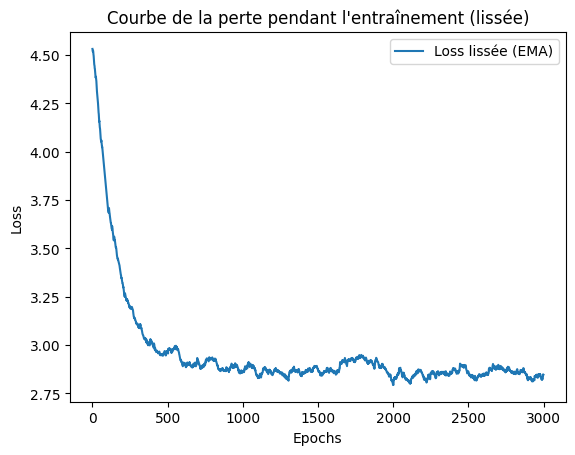


Génération de mots de passe après entraînement :

PPPPPPDcoooaardaarlohtollm
gacisthernkaaneyDJhomma292
1aalaborthoaroolofbmrnkesh
50aanimeglimeotle78aadamle
chaates103aanyrtotonmlskic
JMMgaBMMMMMMaaasthlensytaf
jikahogollvaanrefrlea71297
yqaaroreygotich71aasongoth
4aahhrorotoshicuticototite
7aa11arelaa0969aaaaco11160


In [8]:
!pip install unidecode

import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ensembles des caractères pour les mdp et les interdits
all_characters = string.ascii_letters + string.digits + string.punctuation
selected = string.ascii_letters + string.digits + '&'
not_selected = string.punctuation + string.whitespace
n_characters = len(all_characters)
n_characters_selected = len(selected)
n_characters_not_selected = len(not_selected)


chunk_len = 12

hidden_size = 256
n_layers = 2
lr = 0.005
n_epochs = 3000

# données de train
file = unidecode.unidecode(open("sample_data/train2.txt").read())
file_len = len(file)

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
      if string[c] in not_selected:
        continue
      tensor[c] = selected.index(string[c])
    return tensor.to(device)

def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.n_layers = n_layers

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size, device=device)

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []  # Liste pour stocker toutes les pertes

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    seq_len = inp.size(0)  # Récupérer la longueur du batch actuel
    for c in range(seq_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))
    loss.backward()
    optimizer.step()

    # Ajouter la perte à la liste
    all_losses.append(loss.item() / seq_len)

    return loss.item() / seq_len


def evaluate(prime_str='A', predict_len=25, temperature=0.8):
    if predict_len is None:
        predict_len = random.randint(5, 12)

    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for _ in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
        top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
        predicted_char = selected[top_i]

        if predicted_char == '&':
            break

        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted



def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def exponential_moving_average(values, alpha=0.01):
    ema = []
    avg = values[0]  # Initialisation
    for value in values:
        avg = alpha * value + (1 - alpha) * avg
        ema.append(avg)
    return ema


print("Entraînement sur le dataset de mots de passe...")
start = time.time()
for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    if epoch % 1000 == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

smoothed_losses = exponential_moving_average(all_losses, alpha=0.01)


plt.plot(smoothed_losses, label='Loss lissée (EMA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte pendant l\'entraînement (lissée)')
plt.legend()
plt.show()


# save
if not path.exists("models"):
    makedirs("models")
torch.save(decoder, "models/password_rnn.pt")

print("\nGénération de mots de passe après entraînement :\n")
for _ in range(10):
    print(evaluate(prime_str=random.choice(selected), temperature=0.7))
